In [3]:
import os
import random
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt

from scipy import stats
import scipy.cluster.hierarchy as sch

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [4]:
### READ DATA ###

data, person_id = [], []
for txt in listdir('Walk_MODEL'):
    measure = pd.read_csv('Walk_MODEL/'+txt, sep=' ', header=None).values
    data.append(measure)
    person_id.append(txt.split('-')[-1].split('.')[0])

data = np.asarray(data)
data.shape

(20, 170, 3)

Text(0.5, 0, 'Time')

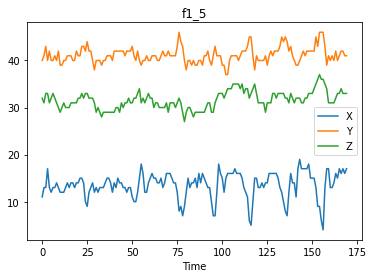

In [5]:
### EXEMPLE OF DATA FOR A SINGLE INDIVIDUAL ###

plt.plot(data[11])
plt.legend(['X','Y','Z'])
plt.title(person_id[11]); plt.xlabel('Time')

In [6]:
### STANDARDIZE DATA ###

for i,s in enumerate(data):
    data[i] = (data[i] - s.mean(axis=0)) / s.std(axis=0)

# DIMENSIONALITY REDUCTION

In [7]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_autoencoder(data):
    
    set_seed(33)

    input_layer = Input(shape=(data.shape[1], data.shape[2]))
    
    encoder = TimeDistributed(Dense(200, activation='tanh'))(input_layer)
    encoder = TimeDistributed(Dense(50, activation='tanh'))(encoder)
    latent = TimeDistributed(Dense(10, activation='tanh'))(encoder)
    decoder = TimeDistributed(Dense(50, activation='tanh'))(latent)
    decoder = TimeDistributed(Dense(200, activation='tanh'))(decoder)

    out = TimeDistributed(Dense(data.shape[2]))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [8]:
autoencoder = get_autoencoder(data)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 170, 3)]          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 170, 200)          800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 170, 50)           10050     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 170, 10)           510       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 170, 50)           550       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 170, 200)          10200     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 170, 3)            603   

In [9]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=0)

autoencoder = get_autoencoder(data)
autoencoder.fit(data[:10],data[:10], epochs=200, verbose=2, validation_data=(data[:10],data[:10]), callbacks=[es])

Epoch 1/200
1/1 - 0s - loss: 0.4698 - val_loss: 0.3912
Epoch 2/200
1/1 - 0s - loss: 0.3912 - val_loss: 0.3193
Epoch 3/200
1/1 - 0s - loss: 0.3193 - val_loss: 0.2531
Epoch 4/200
1/1 - 0s - loss: 0.2531 - val_loss: 0.1931
Epoch 5/200
1/1 - 0s - loss: 0.1931 - val_loss: 0.1413
Epoch 6/200
1/1 - 0s - loss: 0.1413 - val_loss: 0.0999
Epoch 7/200
1/1 - 0s - loss: 0.0999 - val_loss: 0.0696
Epoch 8/200
1/1 - 0s - loss: 0.0696 - val_loss: 0.0502
Epoch 9/200
1/1 - 0s - loss: 0.0502 - val_loss: 0.0410
Epoch 10/200
1/1 - 0s - loss: 0.0410 - val_loss: 0.0402
Epoch 11/200
Restoring model weights from the end of the best epoch.
1/1 - 0s - loss: 0.0402 - val_loss: 0.0441
Epoch 00011: early stopping


Text(0, 0.5, 'mse')

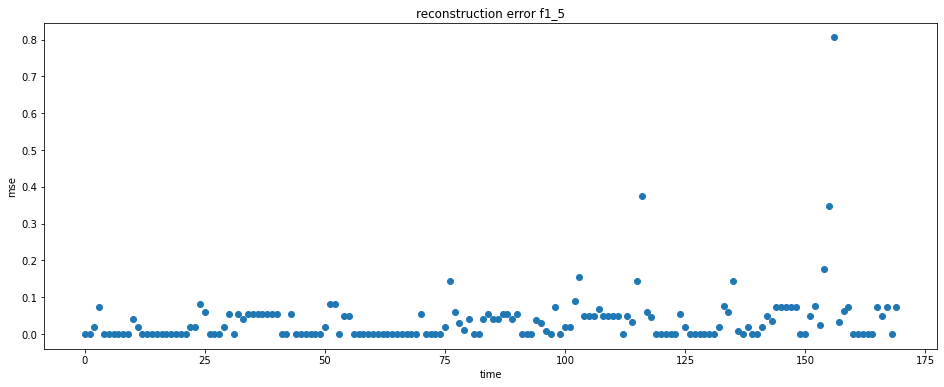

In [10]:
### TRY TO RECONSTRUCT ERRORS ###

predictions = autoencoder.predict(data[[11]])
mse = np.mean(np.power(data[[11]] - predictions, 2), axis=2)

plt.figure(figsize=(16,6))
plt.scatter(range(data.shape[1]), mse)
plt.title('reconstruction error '+person_id[11])
plt.xlabel('time'); plt.ylabel('mse')

# Pearson Correlation CLUSTERING

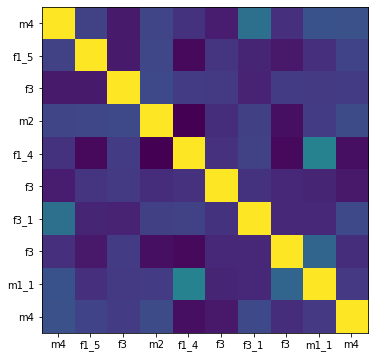

In [11]:
# ### COMPUTE CORRELATION MATRIX ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

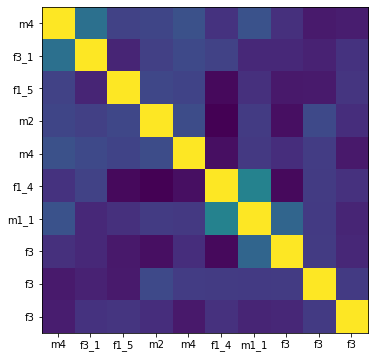

In [12]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(corr)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

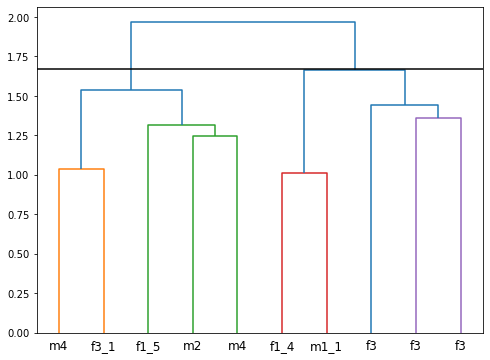

In [13]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')

# Kolmogorov-Smirnov CLUSTERING

In [14]:
def KScoeff(df):
    
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
            
    return ks_matrix

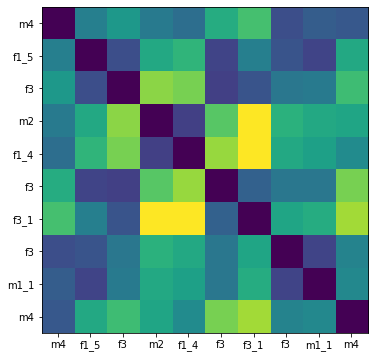

In [15]:
### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

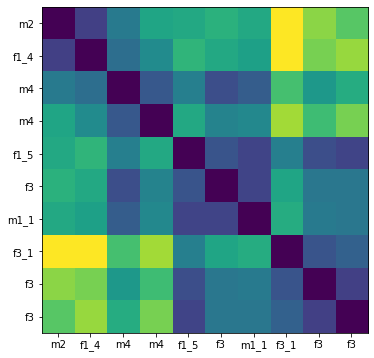

In [16]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

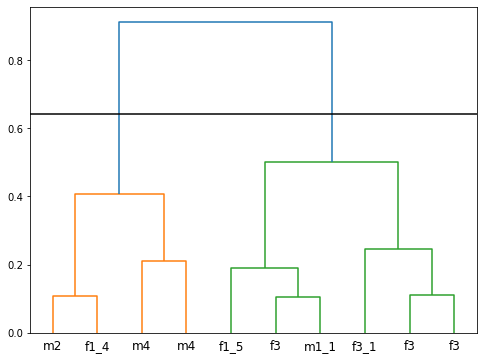

In [17]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')